# LangGraph Chatbot with AWS Lambda tools

![image](https://github.com/vijaynvb/ellucian_gai/blob/main/LangGraph/image.png)

This code block installs the required libraries.

In [1]:
%%capture
!pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt boto3

This code block imports the necessary libraries.

In [2]:
import os
from google.colab import userdata
import boto3
import json
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display

This code block sets up the environment variables.

In [3]:
# Setup environment
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["AWS_ACCESS_KEY_ID"] = userdata.get('AWS_ACCESS_KEY_ID')
os.environ["AWS_SECRET_ACCESS_KEY"] = userdata.get('AWS_SECRET_ACCESS_KEY')
os.environ["AWS_DEFAULT_REGION"] = userdata.get('AWS_DEFAULT_REGION')
os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "tutorial"

# Define AWS Lambda tools

This code block initializes the AWS Lambda client.

In [4]:
lambda_client = boto3.client('lambda', region_name='us-east-1')

This code block defines a tool to fetch ticket details.

In [5]:
@tool
def get_ticket_details(ticket_id: str) -> dict:
    """Fetch ticket details for the provided ticket ID."""
    payload = {"ticket_id": ticket_id}
    response = lambda_client.invoke(
        FunctionName="get_ticket_details",
        InvocationType="RequestResponse",
        Payload=json.dumps(payload),
    )
    return json.load(response["Payload"])

This code block defines a tool to get failure details.

In [6]:
@tool
def get_failure_details(failure_code: str) -> dict:
    """Get detailed information about a failure using the failure code."""
    payload = {"failure_code": failure_code}
    response = lambda_client.invoke(
        FunctionName="get_failure_details",
        InvocationType="RequestResponse",
        Payload=json.dumps(payload),
    )
    return json.load(response["Payload"])

This code block defines a tool to get resolution steps for a failure.

In [7]:
@tool
def fix_failure_steps(failure_code: str) -> dict:
    """Get resolution steps for a given failure code."""
    payload = {"failure_code": failure_code}
    response = lambda_client.invoke(
        FunctionName="fix_failure_steps",
        InvocationType="RequestResponse",
        Payload=json.dumps(payload),
    )
    return json.load(response["Payload"])

This code block defines a tool to search and explain failure details using Amazon Bedrock.

In [14]:
@tool
def search_failure_bedrock(failure_info: dict) -> dict:
    """Search and explain failure details using Amazon Bedrock (Mistral)."""
    failure_code = failure_info.get("failure_code", "")
    description = failure_info.get("description", "")
    query = f"Explain the failure '{description}' and its cause"

    payload = {"query": query}
    response = lambda_client.invoke(
        FunctionName="search_failure_bedrock",
        InvocationType="RequestResponse",
        Payload=json.dumps(payload),
    )
    return json.load(response["Payload"])

This code block defines the list of tools to be used by the chatbot.

In [15]:
tools = [get_ticket_details, get_failure_details, fix_failure_steps, search_failure_bedrock]

# Define LangGraph state

This code block defines the LangGraph state and the chatbot node.

In [16]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"]) ]}

graph_builder.add_node("chatbot", chatbot)

# Define tool execution node

This code block defines the tool execution node.

In [17]:
class BasicToolNode:
    def __init__(self, tools: list):
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        messages = inputs.get("messages", [])
        if not messages:
            raise ValueError("No messages found in input")
        message = messages[-1]
        outputs = []

        for tool_call in message.tool_calls:
            tool_name = tool_call["name"]
            args = tool_call.get("args", {})

            if tool_name == "search_failure_bedrock" and not args:
                failure_code, description = None, None
                for msg in messages:
                    if isinstance(msg, ToolMessage) and msg.name == "get_ticket_details":
                        content = json.loads(msg.content)
                        failure_code = content.get("failureCode")
                        description = content.get("description")
                args = {"failure_info": {"failure_code": failure_code or "UNKNOWN", "description": description or "No description available."}}

            print(f"[INFO] Tool Invoked: {tool_name}")
            result = self.tools_by_name[tool_name].invoke(args)
            outputs.append(ToolMessage(content=json.dumps(result), name=tool_name, tool_call_id=tool_call["id"]))

        return {"messages": outputs}

tool_node = BasicToolNode(tools)
graph_builder.add_node("tools", tool_node)

# Routing logic

This code block defines the routing logic for the LangGraph.

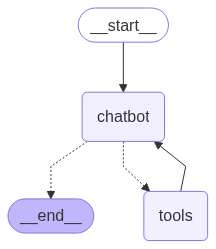

In [18]:
def route_tools(state: State):
    ai_message = state.get("messages", [])[-1] if state.get("messages") else None
    if ai_message and hasattr(ai_message, "tool_calls") and ai_message.tool_calls:
        return "tools"
    return END

graph_builder.add_conditional_edges("chatbot", route_tools, {"tools": "tools", END: END})
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

# Optional visualization
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    pass

This code block contains the interaction loop to ask questions to the chatbot.

In [19]:
# Interaction loop
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            if "messages" in value and value["messages"]:
                print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        user_input = "Hello"
        print("User:", user_input)
        stream_graph_updates(user_input)
        break

User:  Fetch the details for ticket ID TICKET12345, extract the failure code, use it to retrieve the failure details, finally search and explain the failure in detail using GenAI.
Assistant: 
[INFO] Tool Invoked: get_ticket_details
Assistant: {"ticketId": "TICKET12345", "status": "Open", "failureCode": "FAILURE_XYZ_001", "description": "Customer reported service outage.", "failure": true}
Assistant: 
[INFO] Tool Invoked: get_failure_details
Assistant: {"failureCode": "UNKNOWN", "details": "Service outage due to network connectivity issue."}
Assistant: 
[INFO] Tool Invoked: search_failure_bedrock
Assistant: {"statusCode": 200, "body": "\" A \\\"Customer reported service outage\\\" is a situation where a customer has notified the service provider that a particular service they are supposed to be receiving is not working or is unavailable. This could be related to various services such as internet connection, cable TV, phone service, or even a web application or software.\\n\\nThe cause o

These are example prompts to use with the chatbot.

In [ ]:
# prompt1: Fetch the details for ticket ID TICKET12345, extract the failure code, use it to retrieve the failure details, and then obtain the appropriate fix or resolution steps for the identified failure.

# prompt2: Fetch the details for ticket ID TICKET12345, extract the failure code, use it to retrieve the failure details, finally search and explain the failure in detail using GenAI.